In [2]:
# =======================================
# 1. IMPORT LIBRARIES
# =======================================
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm  # Progress bar

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

In [4]:
from transformers import AutoTokenizer, AutoModel
import shap
from imblearn.over_sampling import SMOTE  # Import SMOTE for balancing dataset

In [5]:
# =======================================
# 2. LOAD AND SAMPLE THE DATA
# =======================================
df = pd.read_csv("Crime_Data_from_2020_to_Present.csv")

In [6]:
# Reduce data to first 4000 rows for faster execution
df = df.head(4000)

In [7]:
print("Data sample:\n", df.head(), "\n")

Data sample:
        DR_NO               Date Rptd                DATE OCC  TIME OCC  AREA  \
0  190326475  03/01/2020 12:00:00 AM  03/01/2020 12:00:00 AM      2130     7   
1  200106753  02/09/2020 12:00:00 AM  02/08/2020 12:00:00 AM      1800     1   
2  200320258  11/11/2020 12:00:00 AM  11/04/2020 12:00:00 AM      1700     3   
3  200907217  05/10/2023 12:00:00 AM  03/10/2020 12:00:00 AM      2037     9   
4  200412582  09/09/2020 12:00:00 AM  09/09/2020 12:00:00 AM       630     4   

    AREA NAME  Rpt Dist No  Part 1-2  Crm Cd  \
0    Wilshire          784         1     510   
1     Central          182         1     330   
2   Southwest          356         1     480   
3    Van Nuys          964         1     343   
4  Hollenbeck          413         1     510   

                                Crm Cd Desc  ... Status   Status Desc  \
0                          VEHICLE - STOLEN  ...     AA  Adult Arrest   
1                     BURGLARY FROM VEHICLE  ...     IC   Invest Cont 

In [8]:
# =======================================
# 3. DEFINE THE TARGET
# =======================================
df["is_stolen"] = (df["Crm Cd Desc"] == "VEHICLE - STOLEN").astype(int)

In [9]:
# =======================================
# 4. BUILD A TEXT FEATURE
# =======================================
df["text_feature"] = (
    df["AREA NAME"].fillna("")
    + " "
    + df["Premis Desc"].fillna("")
    + " "
    + df["Status"].fillna("")
    + " "
    + df["LOCATION"].fillna("")
)

In [10]:
# =======================================
# 5. SPLIT TRAIN/TEST
# =======================================
STUDENT_ID = 296726  # Random state for reproducibility

In [11]:
X = df["text_feature"]
y = df["is_stolen"]

In [12]:
# Ensure balanced labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=STUDENT_ID, stratify=y if len(y.unique()) > 1 else None
)

In [13]:
# =======================================
# 6. LOAD TRANSFORMER MODEL
# =======================================
MODEL_NAME = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)

In [15]:
# =======================================
# 7. FUNCTION TO GENERATE EMBEDDINGS (BATCHED)
# =======================================
def get_embeddings(texts, batch_size=32):
    embeddings = []
    print(f"Processing {len(texts)} texts in batches of {batch_size}...")

    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch_texts = texts[i : i + batch_size]
        tokens = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**tokens)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(batch_embeddings)

    print("Embedding generation complete!")
    return np.array(embeddings)

In [16]:
# =======================================
# 8. GENERATE EMBEDDINGS
# =======================================
X_train_emb = get_embeddings(X_train.tolist())
X_test_emb = get_embeddings(X_test.tolist())

Processing 2800 texts in batches of 32...


Generating embeddings: 100%|████████████████████| 88/88 [00:28<00:00,  3.14it/s]


Embedding generation complete!
Processing 1200 texts in batches of 32...


Generating embeddings: 100%|████████████████████| 38/38 [00:11<00:00,  3.18it/s]


Embedding generation complete!


In [17]:
# =======================================
# 9. APPLY SMOTE TO BALANCE CLASSES
# =======================================
print("\nApplying SMOTE to balance training data...")
smote = SMOTE(random_state=STUDENT_ID)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_emb, y_train)


Applying SMOTE to balance training data...


/opt/miniconda3/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
print(f"Balanced dataset: {np.bincount(y_train_balanced)}")  # Check class distribution

Balanced dataset: [2452 2452]


In [19]:
# =======================================
# 10. TRAIN LOGISTIC REGRESSION MODEL ON BALANCED DATA
# =======================================
lr_model = LogisticRegression(random_state=STUDENT_ID)
lr_model.fit(X_train_balanced, y_train_balanced)

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=296726)

In [20]:
# Predict
y_pred = lr_model.predict(X_test_emb)

In [21]:
# Evaluate
f1 = f1_score(y_test, y_pred, pos_label=1)
print("F1-score (is_stolen=1) after SMOTE:", f1)

F1-score (is_stolen=1) after SMOTE: 0.46255506607929514


In [22]:
# Full classification report
print("\nClassification Report After SMOTE:")
print(classification_report(y_test, y_pred))


Classification Report After SMOTE:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1051
           1       0.34      0.70      0.46       149

    accuracy                           0.80      1200
   macro avg       0.65      0.76      0.67      1200
weighted avg       0.88      0.80      0.82      1200



In [23]:
# =======================================
# 11. EXPLAIN MODEL WITH SHAP
# =======================================
explainer = shap.LinearExplainer(lr_model, X_train_balanced)
shap_values = explainer(X_test_emb)


Generating SHAP summary plot...


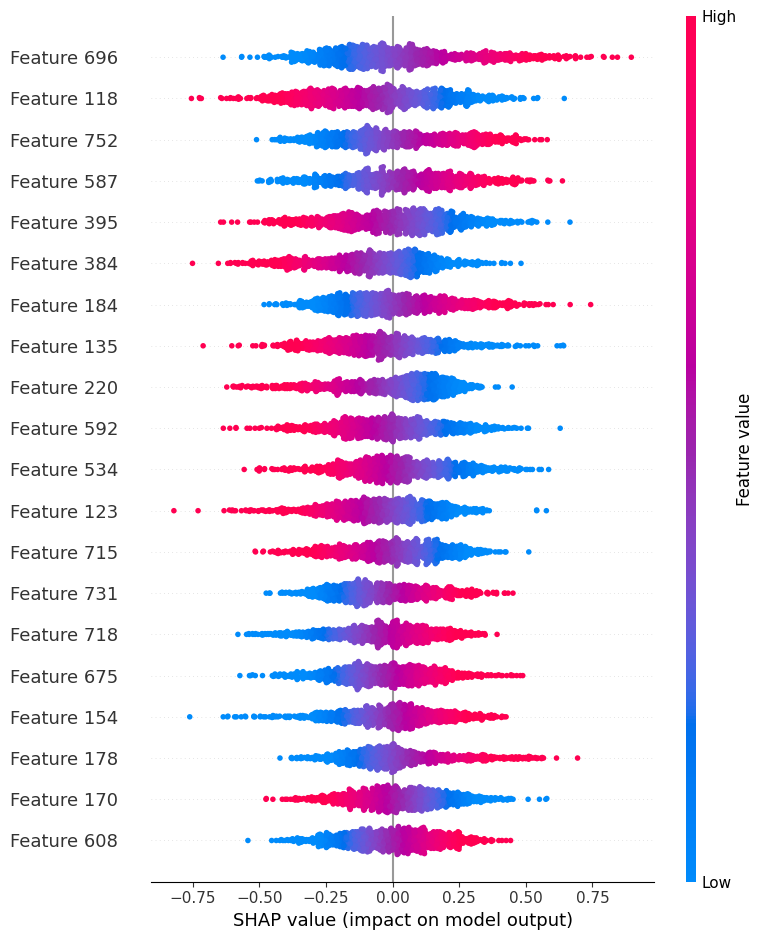

In [24]:
# Global feature importance
print("\nGenerating SHAP summary plot...")
shap.summary_plot(shap_values, X_test_emb)

Generating SHAP waterfall plot for first test sample...


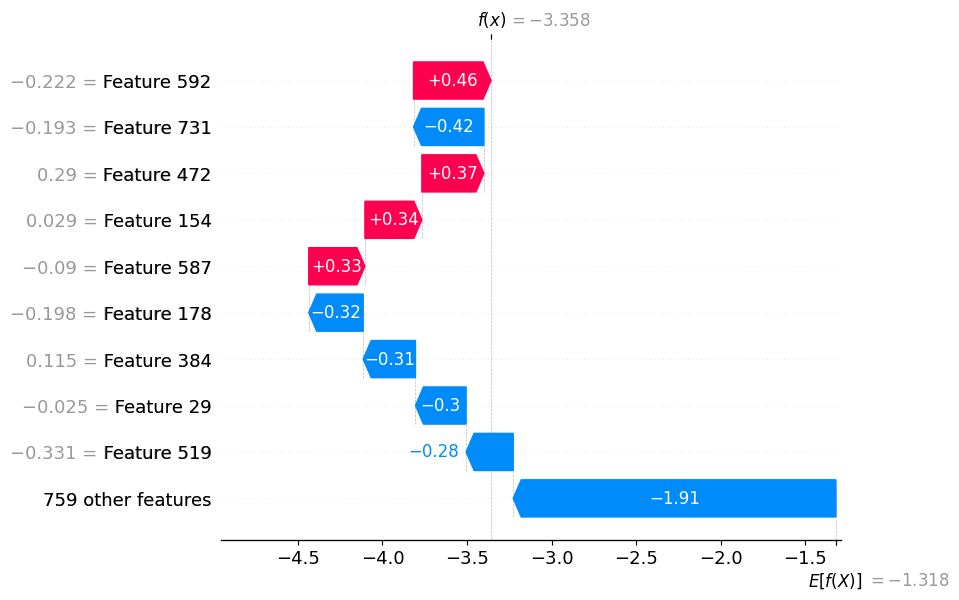

In [25]:
# Local explanation for first test sample
if X_test_emb.shape[0] > 0:
    print("Generating SHAP waterfall plot for first test sample...")
    shap.plots.waterfall(shap_values[0], max_display=10)